In [1]:
import math
import numpy as np
import torch
from torch import nn
from d2l import torch as d2l

In [2]:
max_degree = 20
n_train, n_test = 100, 100
true_w = np.zeros(max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])
features = np.random.normal(size = (n_train + n_test, 1))

In [4]:
features

array([[-1.7961912 ],
       [-0.21166241],
       [-0.63963415],
       [ 1.61342197],
       [-1.82005264],
       [ 0.496865  ],
       [ 0.54613316],
       [-0.64161123],
       [-0.50365096],
       [-0.04839199],
       [ 0.08480727],
       [ 1.6383623 ],
       [ 0.61785461],
       [-0.07507858],
       [ 0.14539956],
       [ 1.56289513],
       [ 0.92922507],
       [-0.10431079],
       [-1.39420515],
       [-0.25825962],
       [-0.63029466],
       [-0.24671591],
       [ 0.1102304 ],
       [ 0.06714253],
       [ 0.17777825],
       [ 2.68953337],
       [-0.04708493],
       [-0.59035584],
       [-1.55673612],
       [-0.737415  ],
       [-0.25214718],
       [ 0.45515415],
       [-0.39295571],
       [ 0.27536048],
       [ 1.66454789],
       [ 0.06078678],
       [ 1.5756399 ],
       [-1.26720126],
       [-0.26507969],
       [ 0.25708104],
       [ 0.1315477 ],
       [-0.84617205],
       [-0.23262279],
       [ 0.597496  ],
       [-0.10290349],
       [-0

In [5]:
np.random.shuffle(features)
poly_features = np.power(features, np.arange(max_degree).reshape(1,-1))

array([[ 1.00000000e+00,  7.85264277e-01,  6.16639985e-01, ...,
         1.64160741e-02,  1.28909565e-02,  1.01228077e-02],
       [ 1.00000000e+00, -1.94851129e-01,  3.79669625e-02, ...,
        -8.41297799e-13,  1.63927826e-13, -3.19415220e-14],
       [ 1.00000000e+00,  2.38560281e-01,  5.69110076e-02, ...,
         2.62523590e-11,  6.26277013e-12,  1.49404820e-12],
       ...,
       [ 1.00000000e+00,  5.07340986e-01,  2.57394877e-01, ...,
         9.77460312e-06,  4.95905679e-06,  2.51593276e-06],
       [ 1.00000000e+00,  1.48619304e-01,  2.20876974e-02, ...,
         8.41935397e-15,  1.25127852e-15,  1.85964142e-16],
       [ 1.00000000e+00, -4.90120890e-01,  2.40218487e-01, ...,
        -5.43443788e-06,  2.66353153e-06, -1.30545244e-06]])

In [6]:
poly_features.shape

(200, 20)

In [7]:
for i in range(max_degree):
    poly_features[:,i] /= math.gamma( i + 1 )
labels = np.dot(poly_features, true_w)
labels = np.random.normal(scale=0.1, size = labels.shape)

In [8]:
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

In [9]:
features[:2], poly_features[:2,:],labels[:2]

(tensor([[ 0.7853],
         [-0.1949]]),
 tensor([[ 1.0000e+00,  7.8526e-01,  3.0832e-01,  8.0704e-02,  1.5844e-02,
           2.4883e-03,  3.2566e-04,  3.6533e-05,  3.5860e-06,  3.1288e-07,
           2.4569e-08,  1.7540e-09,  1.1478e-10,  6.9331e-12,  3.8888e-13,
           2.0358e-14,  9.9916e-16,  4.6153e-17,  2.0135e-18,  8.3216e-20],
         [ 1.0000e+00, -1.9485e-01,  1.8983e-02, -1.2330e-03,  6.0062e-05,
          -2.3406e-06,  7.6013e-08, -2.1159e-09,  5.1535e-11, -1.1157e-12,
           2.1740e-14, -3.8510e-16,  6.2531e-18, -9.3725e-20,  1.3045e-21,
          -1.6945e-23,  2.0636e-25, -2.3653e-27,  2.5604e-29, -2.6258e-31]]),
 tensor([-0.0829, -0.1525]))

In [13]:
def evaluate_loss(net, data_iter, loss):
    metric = d2l.Accumulator(2)
    for X, y in data_iter:
        out = net(X)
        y = y.reshape(out.shape)
        l = loss(out, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [14]:
def train(train_features, test_features, train_labels, test_labels,
          num_epochs=400):
    loss = nn.MSELoss(reduction='none')
    input_shape = train_features.shape[-1]
    # 不设置偏置，因为我们已经在多项式中实现了它
    net = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])
    train_iter = d2l.load_array((train_features, train_labels.reshape(-1,1)),
                                batch_size)
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1,1)),
                               batch_size, is_train=False)
    trainer = torch.optim.SGD(net.parameters(), lr=0.01)
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', yscale='log',
                            xlim=[1, num_epochs], ylim=[1e-3, 1e2],
                            legend=['train', 'test'])
    for epoch in range(num_epochs):
        d2l.train_epoch_ch3(net, train_iter, loss, trainer)
        if epoch == 0 or (epoch + 1) % 20 == 0:
            animator.add(epoch + 1, (evaluate_loss(net, train_iter, loss),
                                     evaluate_loss(net, test_iter, loss)))
    print('weight:', net[0].weight.data.numpy())

weight: [[-0.0162899  -0.0071509  -0.00401308  0.03645782]]


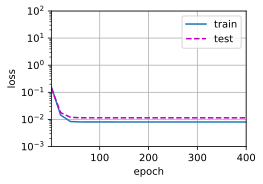

In [15]:
train(poly_features[:n_train, :4], poly_features[n_train:, :4],
      labels[:n_train], labels[n_train:])

weight: [[-0.01809343  0.01245058]]


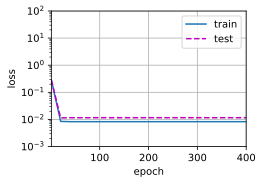

In [16]:
train(poly_features[:n_train, :2], poly_features[n_train:, :2],
      labels[:n_train], labels[n_train:])

weight: [[-0.02234891 -0.00055849  0.0252981   0.00848045 -0.07638825  0.06936228
   0.05558178 -0.10359458  0.20001154  0.22272955 -0.08533692 -0.1961643
  -0.14515786  0.12121315  0.05686307  0.19599694 -0.21027306 -0.11446983
   0.11936188  0.01083069]]


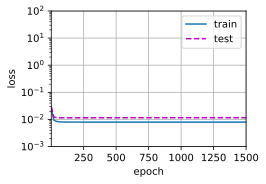

In [17]:
train(poly_features[:n_train, :], poly_features[n_train:, :],
      labels[:n_train], labels[n_train:], num_epochs=1500)